In [1]:
import os
os.environ["MAIN_DIR"] = ""

In [2]:
from rdkit import Chem
from IPython.display import display
import tqdm

mfs = Chem.MolFromSmiles
mts = Chem.MolToSmiles

In [3]:
m = mfs("CC1=CCN(C(C1)C(=O)O)C(=O)C(CC2=CC=C(C=C2)C(=N)N)NS(=O)(=O)C3=CC4=C(CCN(C4)C)C=C3")
Chem.SanitizeMol(m)
mts(m)

'CC1=CCN(C(=O)C(Cc2ccc(C(=N)N)cc2)NS(=O)(=O)c2ccc3c(c2)CN(C)CC3)C(C(=O)O)C1'

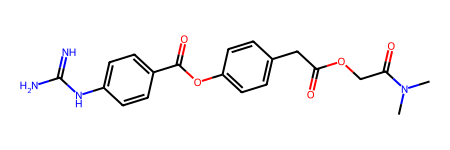

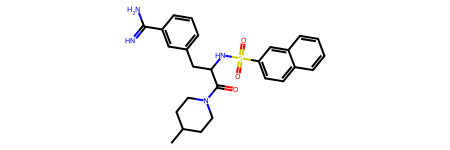

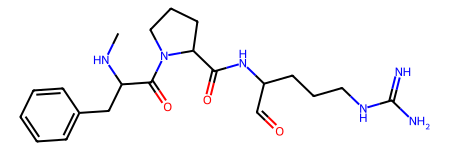

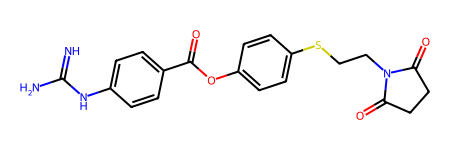

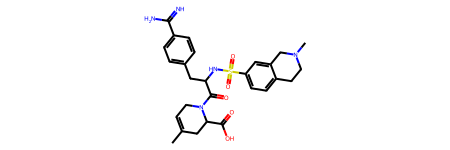

In [4]:
tripsin_mols = [
    "NC(=N)Nc1ccc(C(=O)Oc2ccc(CC(=O)OCC(=O)N(C)C)cc2)cc1",
    "CC1CCN(C(=O)C(Cc2cccc(C(=N)N)c2)NS(=O)(=O)c2ccc3ccccc3c2)CC1",
    "CNC(Cc1ccccc1)C(=O)N1CCCC1C(=O)NC(C=O)CCCNC(=N)N",
    "NC(=N)Nc1ccc(C(=O)Oc2ccc(SCCN3C(=O)CCC3=O)cc2)cc1",
    "CC1=CCN(C(=O)C(Cc2ccc(C(=N)N)cc2)NS(=O)(=O)c2ccc3c(c2)CN(C)CC3)C(C(=O)O)C1",
]

for s in tripsin_mols:
    display(mfs(s))

In [98]:
# from rdkit.Chem import QED
for s in tripsin_mols:
    m = mfs(s)
    print(qed(m))
    print()

0.2775033714829599

0.3568863335305235

0.14588268582099467

0.15922982281318537

0.22479770873550903



# Scaffold

In [5]:
from rdkit.Chem.Scaffolds.MurckoScaffold import GetScaffoldForMol

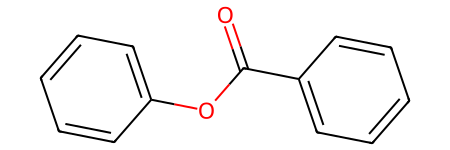

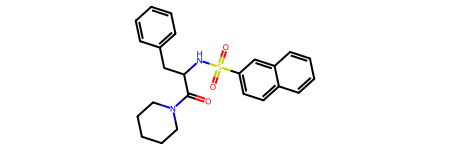

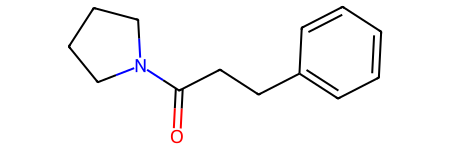

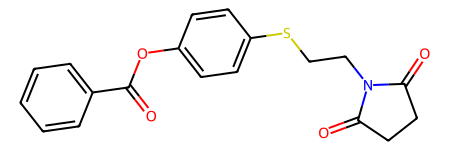

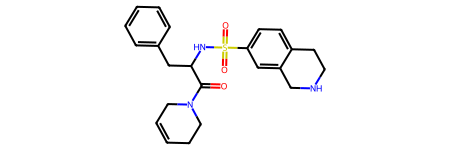

In [6]:
for s in tripsin_mols:
    display(GetScaffoldForMol(mfs(s)))

# All start mols

In [7]:
import pandas as pd
import numpy as np
from rewards.properties import similarity

%time start_mols = list(Chem.SDMolSupplier('datasets/offlineRL/Enamine_Building_Blocks_Stock_266483cmpd_20230901.sdf'))

CPU times: user 29 s, sys: 2.29 s, total: 31.3 s
Wall time: 31.2 s


In [ ]:
from action_utils import get_applicable_actions
from multiprocessing import Pool

temp_mols = []

def error_handled_get_applicable_actions(mol):
    try:
        return get_applicable_actions(mol)
    except:
        return np.zeros(shape=(0,0))

with Pool(30) as P:
    for mol, df in tqdm.tqdm(zip(start_mols, P.imap(error_handled_get_applicable_actions, start_mols, chunksize=100)), total=len(start_mols)):
        if df.shape[0] > 0:
            temp_mols.append(mol)

temp_smiles = list(map(mts, temp_mols))

start_mols_df = pd.DataFrame(temp_smiles, columns=["SMILES"])
start_mols_df

# Filter start mols for experiments

Based on molecules's similarity

In [10]:
df_list = []
for smile in tripsin_mols:
    mol = mfs(smile)
    %time df_list.append( start_mols_df.apply(lambda row: similarity(mfs(row[0]), mol), axis=1))
#     break

mol_sim_df = pd.concat(df_list, axis=1)

CPU times: user 55.6 s, sys: 123 ms, total: 55.7 s
Wall time: 55.7 s
CPU times: user 1min 1s, sys: 25.9 ms, total: 1min 1s
Wall time: 1min 1s
CPU times: user 56.7 s, sys: 38 ms, total: 56.8 s
Wall time: 56.8 s
CPU times: user 56.2 s, sys: 40.8 ms, total: 56.2 s
Wall time: 56.2 s
CPU times: user 1min 5s, sys: 102 ms, total: 1min 5s
Wall time: 1min 5s


Based on scaffold's similarity

In [11]:
df_list = []
for smile in tripsin_mols:
    mol = GetScaffoldForMol(mfs(smile))
    %time df_list.append( start_mols_df.apply(lambda row: similarity(GetScaffoldForMol(mfs(row[0])), mol), axis=1))
#     break

scaf_sim_df = pd.concat(df_list, axis=1)

CPU times: user 57 s, sys: 69.5 ms, total: 57 s
Wall time: 57.1 s
CPU times: user 1min 7s, sys: 64.9 ms, total: 1min 7s
Wall time: 1min 7s
CPU times: user 57.2 s, sys: 79.1 ms, total: 57.2 s
Wall time: 57.3 s
CPU times: user 1min 4s, sys: 79.7 ms, total: 1min 4s
Wall time: 1min 4s
CPU times: user 1min 7s, sys: 59.8 ms, total: 1min 8s
Wall time: 1min 8s


Based on mcs

In [12]:
import tqdm
from rdkit.Chem import rdFMCS

df_list = []
for smile in tripsin_mols:
    mol = GetScaffoldForMol(mfs(smile))
    %time df_list.append( start_mols_df.apply(lambda row: rdFMCS.FindMCS([mol, GetScaffoldForMol(mfs(row[0]))]).numAtoms, axis=1))
    
#     for s2 in tqdm.tqdm(start_mols_df["SMILES"].values):
#         m2 = mfs(s2)
#         mcs = rdFMCS.FindMCS([mol, m2]).numAtoms
#         break
#     break

scaf_mcs_df = pd.concat(df_list, axis=1)

CPU times: user 2min 8s, sys: 162 ms, total: 2min 8s
Wall time: 2min 9s
CPU times: user 4min 32s, sys: 315 ms, total: 4min 32s
Wall time: 4min 32s
CPU times: user 2min 27s, sys: 153 ms, total: 2min 27s
Wall time: 2min 27s
CPU times: user 3min 23s, sys: 237 ms, total: 3min 23s
Wall time: 3min 23s
CPU times: user 4min 40s, sys: 304 ms, total: 4min 40s
Wall time: 4min 40s


Create list of starting mols

In [13]:
# THere's some smiles in start_mols that have more than 1 molecule ("X.Y.Z" etc). Get the biggest molecule of these
def get_single_smile_mol(smile):
    s = smile.split(".")
    n = list(map(len, s))
    return s[np.argmax(n)]

start_mols_df["SMILES"] = start_mols_df["SMILES"].apply(get_single_smile_mol)

In [14]:
start_mols_for_experiments = []
n = 100

for i, s1 in enumerate(tripsin_mols):
    mol = mfs(s1)
    temp = []
    
    # Mol sim
    temp += start_mols_df.loc[mol_sim_df.sort_values(i, ascending=False).index[:n]]["SMILES"].values.tolist()
    
    # scaf sim
    temp += start_mols_df.loc[scaf_sim_df.sort_values(i, ascending=False).index[:n]]["SMILES"].values.tolist()
    
    # scaf mcs
    val = scaf_mcs_df.sort_values(i, ascending=False)[i].values[n-1]
    temp += start_mols_df.loc[scaf_sim_df[scaf_mcs_df[i] >= val].sort_values(i, ascending=False).index[:n]]["SMILES"].values.tolist()
    
    start_mols_for_experiments.append(np.unique(temp)[:200])

# PREDICTIONS!

In [16]:
import torch

In [17]:
device = torch.device("cuda:2" if torch.cuda.is_available() else "cpu")

In [18]:
%run supervised_functions.ipynb

Calculating probability for start mol sampling


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 66546/66546 [01:43<00:00, 643.53it/s]


In [19]:
action_dataset = pd.read_csv("datasets/my_uspto/action_dataset-filtered.csv", index_col=0)
action_dataset = action_dataset.loc[action_dataset["action_tested"] & action_dataset["action_works"]]
action_dataset = action_dataset[["rsub", "rcen", "rsig", "rsig_cs_indices", "psub", "pcen", "psig", "psig_cs_indices"]]
print(action_dataset.shape)

action_rsigs = data.Molecule.pack(list(map(molecule_from_smile, action_dataset["rsig"])))
action_psigs = data.Molecule.pack(list(map(molecule_from_smile, action_dataset["psig"])))

(84968, 8)


/home/abhor/miniconda3/envs/de_novo/lib/python3.7/site-packages/torchdrug-0.2.0-py3.7.egg/torchdrug/data/feature.py:42: UserWarning: Unknown value `Li`
  warnings.warn("Unknown value `%s`" % x)
/home/abhor/miniconda3/envs/de_novo/lib/python3.7/site-packages/torchdrug-0.2.0-py3.7.egg/torchdrug/data/feature.py:42: UserWarning: Unknown value `Ga`
  warnings.warn("Unknown value `%s`" % x)
/home/abhor/miniconda3/envs/de_novo/lib/python3.7/site-packages/torchdrug-0.2.0-py3.7.egg/torchdrug/data/feature.py:42: UserWarning: Unknown value `Na`
  warnings.warn("Unknown value `%s`" % x)
/home/abhor/miniconda3/envs/de_novo/lib/python3.7/site-packages/torchdrug-0.2.0-py3.7.egg/torchdrug/data/feature.py:42: UserWarning: Unknown value `Al`
  warnings.warn("Unknown value `%s`" % x)
/home/abhor/miniconda3/envs/de_novo/lib/python3.7/site-packages/torchdrug-0.2.0-py3.7.egg/torchdrug/data/feature.py:42: UserWarning: Unknown value `Ti`
  warnings.warn("Unknown value `%s`" % x)
/home/abhor/miniconda3/envs/de

In [20]:
import time
def get_topk_predictions(model, source_list, target_list, topk=10):
    # Convert to mols
    if isinstance(source_list, pd.Series):
        source_list = source_list.tolist()
    if isinstance(target_list, pd.Series):
        target_list = target_list.tolist()
    tt = time.time()
    sources = data.Molecule.pack(list(map(molecule_from_smile, source_list)))
    targets = data.Molecule.pack(list(map(molecule_from_smile, target_list)))
    print(f"Took {time.time() - tt}s to pack molecules.")

    # Predictions
    batch_size = 1024
#     pred = model(sources, targets, None, None, "actor").detach()
    pred = torch.concatenate([model(sources[i:min(i+batch_size, sources.batch_size)].to(device), 
                                 targets[i:min(i+batch_size, sources.batch_size)].to(device), None, None, "actor").detach() for i in range(0, sources.batch_size, batch_size)], axis=0)

    action_embeddings = get_action_dataset_embeddings(model.GIN)

    # Get applicable actions for source(s)
    applicable_action_indices_list = []
    
    with Pool(30) as p:
        for idxes in tqdm.tqdm(p.imap(functools.partial(get_emb_indices_and_correct_idx, no_correct_idx=True), 
                                      [{"reactant": source_list[i]} for i in range(pred.shape[0])], chunksize=10),
                              total=pred.shape[0]):
            applicable_action_indices_list.append(idxes)

    # Sort by critic's Q
    dict_of_list_of_indices = {}
    
    for i in tqdm.tqdm(range(pred.shape[0])):
        pred_for_i = pred[i]
        adi = applicable_action_indices_list[i]
        if len(adi) == 0:
            dict_of_list_of_indices[i] = np.array([])
            continue

        # Get top 50 for actor
        dist = torch.linalg.norm(action_embeddings[adi] - pred[i], axis=1)
        dict_of_list_of_indices[i] = adi[torch.argsort(dist)[:50].cpu().numpy().astype(np.int64)]

    # Sort with critic's Q
    i_sorted = list(range(pred.shape[0]))
    action_indices = np.concatenate([dict_of_list_of_indices[i] for i in i_sorted])
    state_indices = np.concatenate([np.full_like(dict_of_list_of_indices[i], i) for i in i_sorted])
    critic_qs = []
    for i in tqdm.tqdm(range(0, action_indices.shape[0], batch_size)):
        batch_reactants = sources[state_indices[i:i+batch_size]]
        batch_products = targets[state_indices[i:i+batch_size]]
        batch_rsigs = action_rsigs[action_indices[i:i+batch_size]]
        batch_psigs = action_psigs[action_indices[i:i+batch_size]]
        critic_qs.append(ac(batch_reactants.to(device), batch_products.to(device), batch_rsigs.to(device), batch_psigs.to(device), "critic").detach().cpu().numpy())

    critic_qs = np.concatenate(critic_qs)

    # Get action predictions
    action_pred_indices = []
    start = 0
    for i in tqdm.tqdm(i_sorted):
        end = start + dict_of_list_of_indices[i].shape[0]
        i_critic_qs = critic_qs[start:end]

        action_pred_indices.append(dict_of_list_of_indices[i][i_critic_qs.reshape(-1).argsort()[::-1]][:topk])
        start = end

    return action_pred_indices
    
# %time pred = get_topk_predictions(ac, source_list[:100], target_list[target_list_idx][:100])
# print(len(pred))

In [21]:
def apply_actions_on_reactant(args):
    reactant, action_dataset_idx = args
    listy = []
    for idx in action_dataset_idx:
        try:
            listy.append(Chem.MolToSmiles(apply_action(Chem.MolFromSmiles(reactant), *action_dataset.iloc[idx])))
        except Exception as e:
            pass
    return listy

In [22]:
def get_similarity_from_smiles(s1, s2):
    return similarity(Chem.MolFromSmiles(s1), Chem.MolFromSmiles(s2))

In [179]:
target_list = []
for i in range(len(tripsin_mols)):
    target_list += [tripsin_mols[i] for j in range(len(start_mols_for_experiments[i]))]
target_list = np.array(target_list)
    
source_list = np.concatenate(start_mols_for_experiments)

print(source_list.shape, target_list.shape)

(1000,) (1000,)


Load model

In [180]:
# Load model
import glob
file_string = f"models/supervised/actor-critic/steps=5||actor_loss=PG||negative_selection=random/model.pth"
ac = torch.load(glob.glob(file_string)[0]).to(device)

In [181]:
%%time

target_list_idx = np.arange(target_list.shape[0])
sim_dict = {}
trajectory_dict = {str(i): source_list[i] for i in range(len(source_list))} # Keeps track of trajectory in dict format (need hash keeys for quick access)
source_keys = list(map(str, np.arange(len(source_list)))) # Map for index to keys of previous step in trajectory

# RUN -----------------------
for i_step in range(1, 5): 
    print("Running prediction for step", i_step)
    # Get action predictions
    pred = get_topk_predictions(ac, source_list, target_list[target_list_idx], topk=10)

    # get products
    temp_source_keys = []
    temp_source_list = []
    with Pool(30) as p:
        print("Applying actions for step", i_step)
        for i, product_list in tqdm.tqdm(enumerate(p.imap(apply_actions_on_reactant, zip(source_list, pred), chunksize=10)), total=len(pred)):
            for _i, product in enumerate(product_list):
                key = f"{source_keys[i]}_{_i}"
                trajectory_dict[key] = product
                sim_dict[key] = get_similarity_from_smiles(product, target_list[int(key.split("_")[0])])
                temp_source_keys.append(key)
                temp_source_list.append(product)

    print("Getting top some sim products for each s-t pair")
    temp_source_keys = np.array(temp_source_keys)
    temp_source_list = np.array(temp_source_list)
    temp_source_sim = np.vectorize(sim_dict.get)(temp_source_keys)
    temp_source_argsort = np.argsort(temp_source_sim)
    temp_source_st_idx = np.array(list(map(lambda x: int(x.split("_")[0]), temp_source_keys)))
    temp_source_indices = []
    for t_i in range(target_list.shape[0]):
        temp_source_indices.append((temp_source_argsort[temp_source_st_idx == t_i])[:1000])

    temp_source_indices = np.concatenate(temp_source_indices)

    # update source list and source_keys for next step
    source_keys = temp_source_keys[temp_source_indices]
    source_list = temp_source_list[temp_source_indices]
    target_list_idx = list(map(lambda x: int(x.split("_")[0]), source_keys))

Running prediction for step 1
Took 2.984896421432495s to pack molecules.


100%|█████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 99981.03it/s]


Applying actions for step 1


100%|███████████████████████████████████████████████████████████| 1000/1000 [00:08<00:00, 121.85it/s]


Getting top some sim products for each s-t pair
Running prediction for step 2
Took 29.478561401367188s to pack molecules.


100%|████████████████████████████████████████████████████████| 9386/9386 [00:00<00:00, 109989.40it/s]


Applying actions for step 2


100%|███████████████████████████████████████████████████████████| 9386/9386 [01:19<00:00, 117.81it/s]


Getting top some sim products for each s-t pair
Running prediction for step 3
Took 289.5454206466675s to pack molecules.


100%|██████████████████████████████████████████████████████| 87639/87639 [00:00<00:00, 191236.07it/s]


Applying actions for step 3


100%|█████████████████████████████████████████████████████████| 87639/87639 [13:31<00:00, 108.02it/s]


Getting top some sim products for each s-t pair
Running prediction for step 4


/home/abhor/miniconda3/envs/de_novo/lib/python3.7/site-packages/torchdrug-0.2.0-py3.7.egg/torchdrug/data/feature.py:42: UserWarning: Unknown value `Na`
  warnings.warn("Unknown value `%s`" % x)


Took 2984.073226451874s to pack molecules.


100%|████████████████████████████████████████████████████| 806291/806291 [00:03<00:00, 207148.82it/s]


Applying actions for step 4


100%|█████████████████████████████████████████████████████| 806291/806291 [2:11:48<00:00, 101.95it/s]


Getting top some sim products for each s-t pair
Running prediction for step 5
Took 3821.480736732483s to pack molecules.


100%|████████████████████████████████████████████████████| 971901/971901 [00:04<00:00, 207006.09it/s]


Applying actions for step 5


100%|██████████████████████████████████████████████████████| 971901/971901 [2:52:20<00:00, 93.99it/s]


Getting top some sim products for each s-t pair
CPU times: user 3d 13h 34min 4s, sys: 8h 47min 36s, total: 3d 22h 21min 40s
Wall time: 13h 34min 1s


In [182]:
all_keys = np.array(list(trajectory_dict.keys()))

def t_map(x):
    return x.split("_")[0]
%time target_map_for_all_keys = np.vectorize(t_map)(all_keys)

sim_dict = {}

def my_convenient_similarity_fn(s1, m2):
    return similarity(Chem.MolFromSmiles(s1), m2)

with Pool(30) as p:
    for i in tqdm.tqdm(range(target_list.shape[0])):
        target_mol = Chem.MolFromSmiles(target_list[i])
        
        # Get for others
        key_for_i = all_keys[target_map_for_all_keys == str(i)]
        for _i, sim in enumerate(p.imap(functools.partial(my_convenient_similarity_fn, m2=target_mol), np.vectorize(trajectory_dict.get)(key_for_i), chunksize=10)):
            sim_dict[key_for_i[_i]] = sim

CPU times: user 7.62 s, sys: 938 ms, total: 8.56 s
Wall time: 8.55 s


100%|████████████████████████████████████████████████████████████| 1000/1000 [15:41<00:00,  1.06it/s]


In [228]:
import pickle
pickle.dump(target_list, open("models/onlineRL_sim/data/LOGRL_target_list.pickle", 'wb'))
pickle.dump(trajectory_dict, open("models/onlineRL_sim/data/LOGRL_traj_dict.pickle", 'wb'))
pickle.dump(sim_dict, open("models/onlineRL_sim/data/LOGRL_sim_dict.pickle", 'wb'))

In [217]:
%time sim_arr = np.vectorize(sim_dict.get)(all_keys)
sorted_sim_arr = np.sort(sim_arr)[::-1]

CPU times: user 4.79 s, sys: 436 ms, total: 5.22 s
Wall time: 5.17 s


In [219]:
def get_top_keys(n):
    i = n
    for i in range(int(1.2*n), n, -1):
        relevant_keys= all_keys[sim_arr >= sorted_sim_arr[i]]
        relevant_keys = np.array(list(filter(lambda x: len(x.split("_")) <= 5, relevant_keys)))
        relevant_smiles = np.unique(np.vectorize(trajectory_dict.get)(relevant_keys))
        if relevant_smiles.shape[0] < n:
            break

    relevant_keys = all_keys[sim_arr >= sorted_sim_arr[i+1]]
    relevant_keys = np.array(list(filter(lambda x: len(x.split("_")) <= 5, relevant_keys)))

    temp_set = set()
    temp_keys = []
    for key in relevant_keys:
        if trajectory_dict[key] in temp_set:
            continue
        temp_keys.append(key)
        temp_set.add(trajectory_dict[key])
        
    temp_sim = [sim_dict[key] for key in temp_keys]
    for i in range(len(temp_keys) - n):
        miny = np.argmin(temp_sim)
        temp_sim.pop(miny)
        temp_keys.pop(miny)

    return np.array(temp_keys)
    

for i in [1, 10, 100, 1000, 10000]:
    relevant_keys = get_top_keys(i)
    qed_arr = np.array(list(map(lambda x: qed(mfs(x)), np.vectorize(trajectory_dict.get)(relevant_keys))))
    mean_sim = np.mean(np.vectorize(sim_dict.get)(relevant_keys))
    q_min = qed_arr.min()
    q_mean = qed_arr.mean()
    q_max = qed_arr.max()
    
    print(f"{i}\t" + "\t".join(list(map(lambda x: str(round(x, 3)), [mean_sim, q_min, q_mean, q_max]))))

1	0.791	0.262	0.262	0.262
10	0.764	0.127	0.244	0.321
100	0.714	0.088	0.281	0.624
1000	0.648	0.045	0.299	0.791
10000	0.57	0.023	0.293	0.889


In [225]:
sns.displot(qed_arr, hue="species", kind="kde", fill=True)

ValueError: The following variable cannot be assigned with wide-form data: `hue`

## Using mols with sim above 0.6

In [194]:
def path_len(traj):
    return len(traj.split("_")) - 1

%time temp_len_arr = np.vectorize(path_len)(all_keys)

all_keys = all_keys[temp_len_arr <= 4]
all_keys.shape

CPU times: user 6.46 s, sys: 376 ms, total: 6.84 s
Wall time: 6.83 s


In [184]:
sim_list = np.vectorize(sim_dict.get)(all_keys)

sim_list.max()

0.7912087912087912

In [198]:
cutoff = 0.6
relevant_keys= all_keys[np.vectorize(sim_dict.get)(all_keys) > cutoff]
relevant_keys = np.array(list(filter(lambda x: len(x.split("_")) >= 4, relevant_keys)))
temp_smiles = np.vectorize(trajectory_dict.get)(relevant_keys)
# temp_sim = vp.vectorize(sim_dict.get)(relevant_keys)
# temp_sim = temp_sim.sort()[::-1]
relevant_keys = pd.DataFrame({"keys": relevant_keys, "smiles": temp_smiles}).drop_duplicates("smiles", keep="first")["keys"].values
print(relevant_keys.shape)

a = list(map(lambda x: len(x.split("_")), relevant_keys))
pd.value_counts(a)

(1052,)


5    624
4    428
dtype: int64

## QED

In [147]:
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

In [148]:
from rewards.properties import qed

qed_arr = []
for key in tqdm.tqdm(relevant_keys):
    mol = mfs(trajectory_dict[key])
    Chem.SanitizeMol(mol)
    qed_arr.append(qed(mol))
qed_arr = np.array(qed_arr)


tripsin_qed = list(map(lambda x: qed(mfs(x)), tripsin_mols))

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1052/1052 [00:02<00:00, 486.25it/s]


In [ ]:
       RL sim | RL s-t


Text(0.5, 1.0, 'FSP3G distribution')

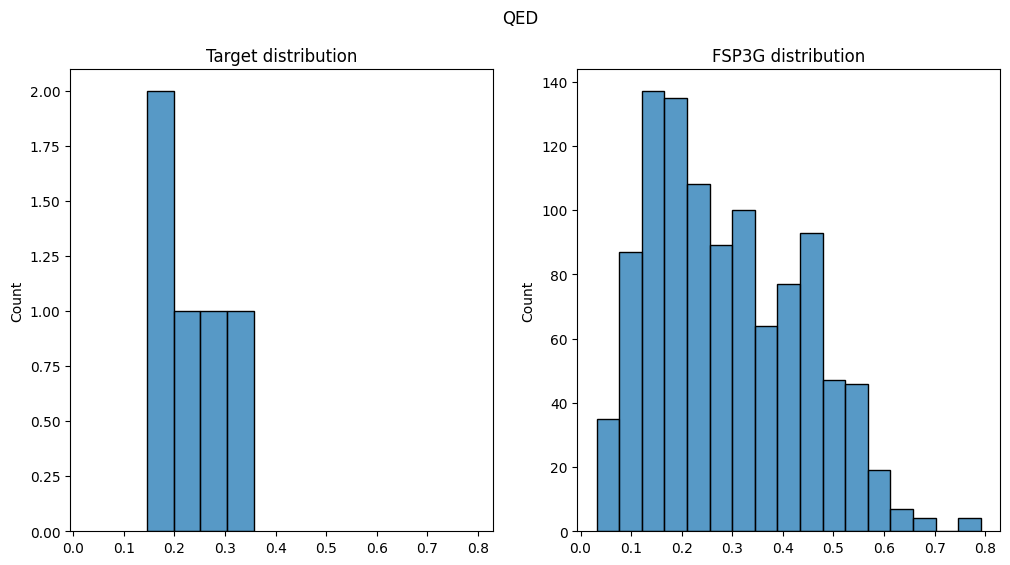

In [149]:
fig, ax = plt.subplots(1, 2, sharex=True, figsize=(12,6))
sns.histplot(tripsin_qed, ax=ax[0])
sns.histplot(qed_arr, ax=ax[1])
fig.suptitle("QED")
ax[0].set_title("Target distribution")
ax[1].set_title("FSP3G distribution")

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1052/1052 [00:00<00:00, 1149.95it/s]


Text(0.5, 1.0, 'FSP3G distribution')

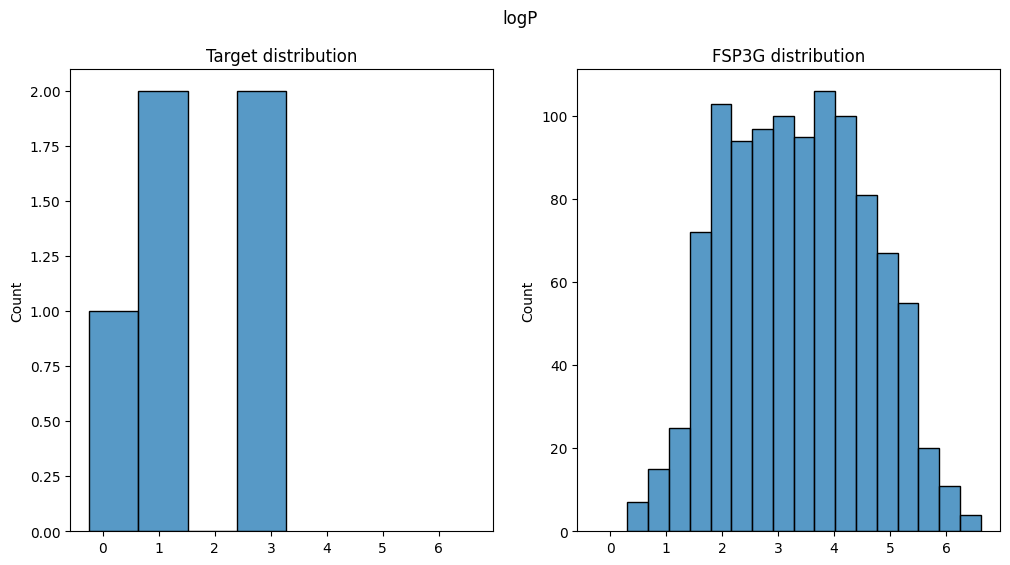

In [150]:
from rewards.properties import logP

logP_arr = []
for key in tqdm.tqdm(relevant_keys):
    mol = mfs(trajectory_dict[key])
    Chem.SanitizeMol(mol)
    logP_arr.append(logP(mol))
logP_arr = np.array(logP_arr)


tripsin_logP = list(map(lambda x: logP(mfs(x)), tripsin_mols))


fig, ax = plt.subplots(1, 2, sharex=True, figsize=(12,6))
sns.histplot(tripsin_logP, ax=ax[0])
sns.histplot(logP_arr, ax=ax[1])
fig.suptitle("logP")
ax[0].set_title("Target distribution")
ax[1].set_title("FSP3G distribution")

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1052/1052 [00:01<00:00, 868.89it/s]


Text(0.5, 1.0, 'FSP3G distribution')

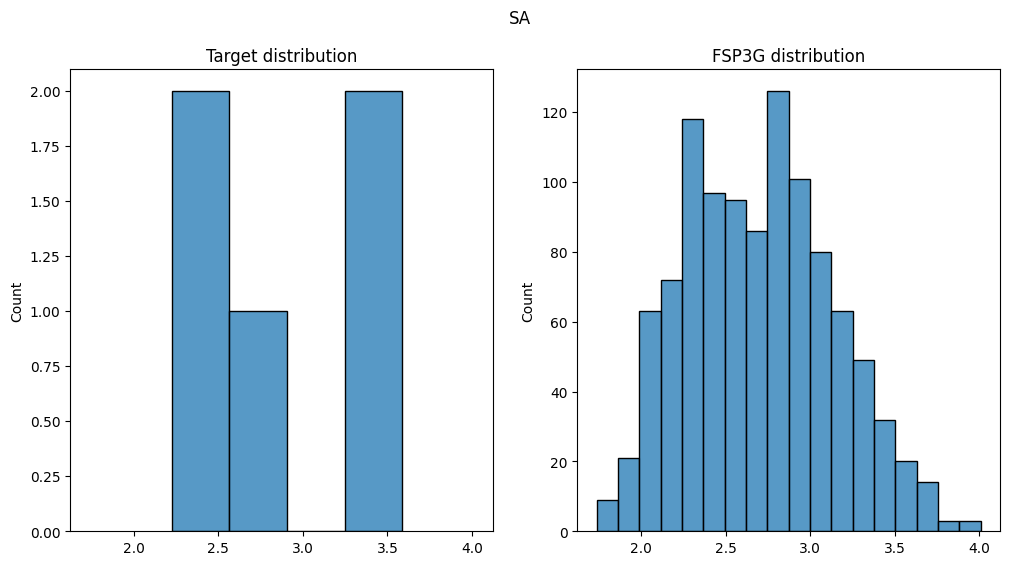

In [151]:
from rewards.properties import SA

SA_arr = []
for key in tqdm.tqdm(relevant_keys):
    mol = mfs(trajectory_dict[key])
    Chem.SanitizeMol(mol)
    SA_arr.append(SA(mol))
SA_arr = np.array(SA_arr)


tripsin_SA = list(map(lambda x: SA(mfs(x)), tripsin_mols))


fig, ax = plt.subplots(1, 2, sharex=True, figsize=(12,6))
sns.histplot(tripsin_SA, ax=ax[0])
sns.histplot(SA_arr, ax=ax[1])
fig.suptitle("SA")
ax[0].set_title("Target distribution")
ax[1].set_title("FSP3G distribution")

# Looking at molecules

In [165]:
tripsin_mol_index_for_relevant_keys = np.array(list(map(lambda x: int(x.split("_")[0])//200, relevant_keys)))
pd.value_counts(tripsin_mol_index_for_relevant_keys)

3    447
1    354
0    249
2      2
dtype: int64

In [162]:
temp = qed_arr.copy()
temp.sort()
temp = temp[::-1]

[0.63793103 0.61458333 0.65625    0.61956522 0.6344086  0.60227273
 0.60227273 0.61797753 0.65909091 0.6344086  0.61702128 0.65217391
 0.62393162 0.62222222 0.61956522 0.6344086  0.60194175 0.72727273
 0.60227273 0.72222222 0.70786517]


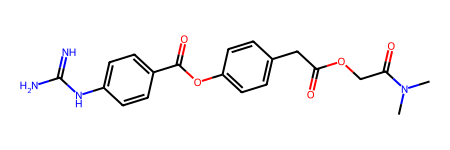

QED = 0.278 || logP = 1.385 || SA = 2.225


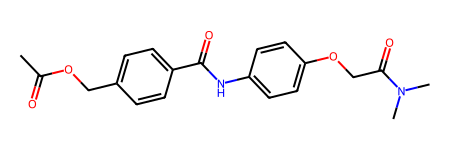

QED = 0.757 || logP = 2.469 || SA = 1.848 || sim(target) = 0.615
######################################################################################################################################################
######################################################################################################################################################


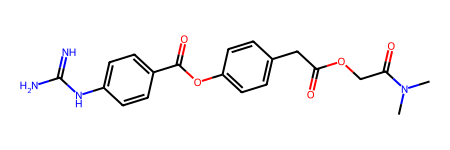

QED = 0.278 || logP = 1.385 || SA = 2.225


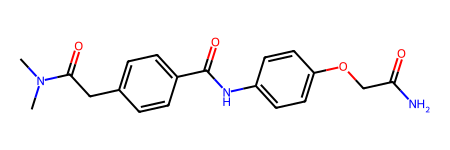

QED = 0.784 || logP = 1.434 || SA = 1.843 || sim(target) = 0.652
######################################################################################################################################################
######################################################################################################################################################


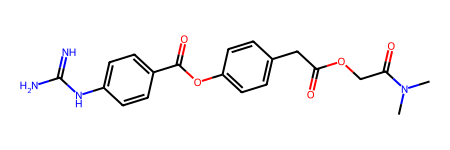

QED = 0.278 || logP = 1.385 || SA = 2.225


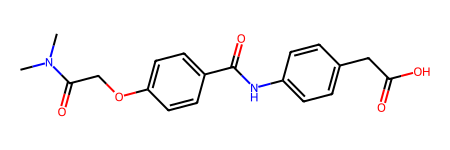

QED = 0.791 || logP = 2.033 || SA = 1.803 || sim(target) = 0.634
######################################################################################################################################################
######################################################################################################################################################


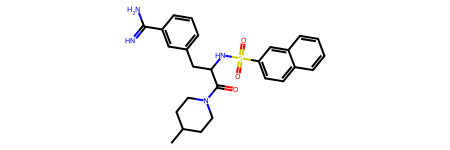

QED = 0.357 || logP = 3.272 || SA = 2.786


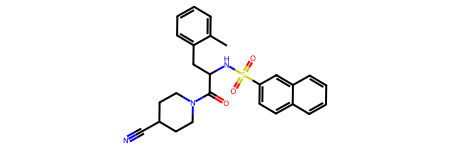

QED = 0.605 || logP = 3.8 || SA = 2.846 || sim(target) = 0.638
######################################################################################################################################################
######################################################################################################################################################


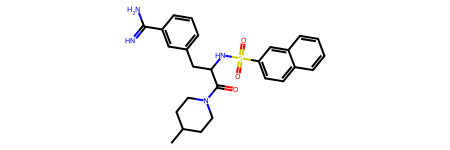

QED = 0.357 || logP = 3.272 || SA = 2.786


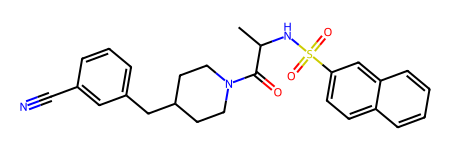

QED = 0.604 || logP = 3.86 || SA = 2.771 || sim(target) = 0.624
######################################################################################################################################################
######################################################################################################################################################


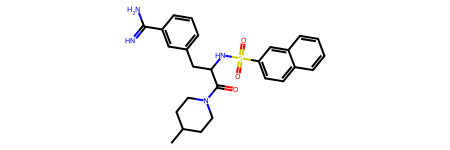

QED = 0.357 || logP = 3.272 || SA = 2.786


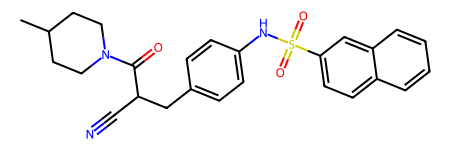

QED = 0.582 || logP = 4.581 || SA = 2.792 || sim(target) = 0.624
######################################################################################################################################################
######################################################################################################################################################


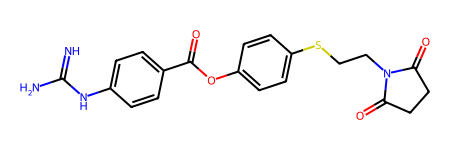

QED = 0.159 || logP = 2.452 || SA = 2.416


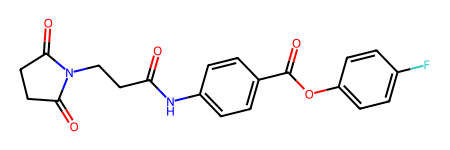

QED = 0.469 || logP = 2.522 || SA = 1.99 || sim(target) = 0.677
######################################################################################################################################################
######################################################################################################################################################


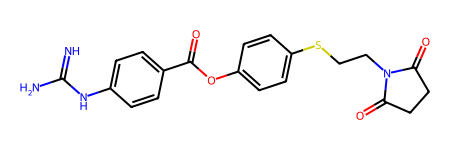

QED = 0.159 || logP = 2.452 || SA = 2.416


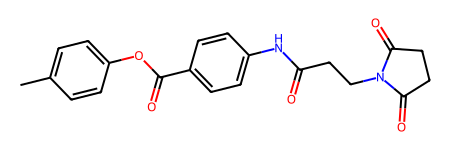

QED = 0.472 || logP = 2.692 || SA = 1.973 || sim(target) = 0.677
######################################################################################################################################################
######################################################################################################################################################


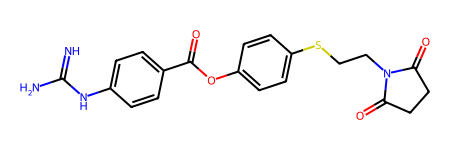

QED = 0.159 || logP = 2.452 || SA = 2.416


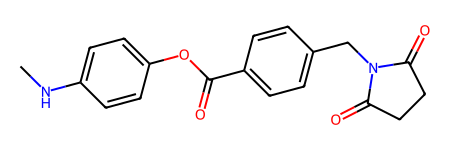

QED = 0.515 || logP = 2.597 || SA = 2.003 || sim(target) = 0.628
######################################################################################################################################################
######################################################################################################################################################


In [172]:
def cute_display(key=None, mol=None):
    if key:
        mol = mfs(trajectory_dict[key])
    display(mol)
    g = lambda x: round(x, 3)
    print(f"QED = {g(qed(mol))} || logP = {g(logP(mol))} || SA = {g(SA(mol))}", end="")
    if key is not None:
        print(f" || sim(target) = {g(sim_dict[key])}")
    else:
        print()

for i in [0, 1, 3]:
    temp_keys = relevant_keys[tripsin_mol_index_for_relevant_keys == i]
    temp_qed = qed_arr[tripsin_mol_index_for_relevant_keys == i]
    temp_sorted = np.sort(temp_qed)[::-1]
    for key in temp_keys[temp_qed >= temp_sorted[2]]:
        cute_display(mol=mfs(tripsin_mols[i]))
        cute_display(key=key)
        print("#"*150)
        print("#"*150)